## Imports

Since I have not worked with PGMs in a very long time (and also not in Python), I found this library called edward, which seemed promising. It was only until much later that I discovered there is a much newer version as part of the tensorflow probability package, hence the old versions of tensorflow and edward.

In [1]:
import tensorflow as tf
print("tensorflow version: %s" % tf.__version__)
import edward as ed
print("edward version: %s" % ed.__version__)
import edward.models as edm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import gamma
import edward.inferences as edi
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Set the random seed
tf.set_random_seed(10)
np.random.seed(5)

## Set constants

In [3]:
# Average number of days that a blueberry spends in each phase. The last one is not 0 for numerical stability.
PHASE_SHIFT_DAYS = [21., 18., 11., 5., 3., 0.1] 
PHASES = 6
N = 1 # Number of samples to process at a time
PHASE_COLUMNS = ['green', 'colour_break_1', 'colour_break_2', 'pink', 'cherry', 'blue']
# When doing the weight prediction, we sample from the posterior over the number of blueberries. 
# This is the number of samples to use.
SAMPLES_WEIGHTS = 10

## Modelling choices

I have split up the problem into two parts. The first one is finding out how many blueberries will be ready for harvest after 7 days, and the second is what is predicting the total weight of those blueberries.

### Blueberry numbers prediction

I have chosen to represent the first problem using a graphical model. Each phase has four random variables:

$ I_{i} - \text{Observed number of blueberries in phase $i$ (inputs)} \\
G_{1} - \text{Number of blueberries that will start to grow (grow)} \\
S_{i} - \text{Number of blueberries that will move on from phase $i$ due to ripening or falling off the tree (shifts)} \\
O_{i} - \text{Observed number of blueberries in phase $i$ (outputs)}$

For the simplicity of inference all random variables will be normally distributed. According to the graph, the joint probability factorises as
$$p(I_{0:5}, G_{0}, O_{0:5}, S_{0:5}) = p(G_0)\prod_i p(I_{i})p(S_i|I_i)p(O_i|S_{i-1}, S_{i}, I_{i}) $$
where $S_{-1} = G_0$.

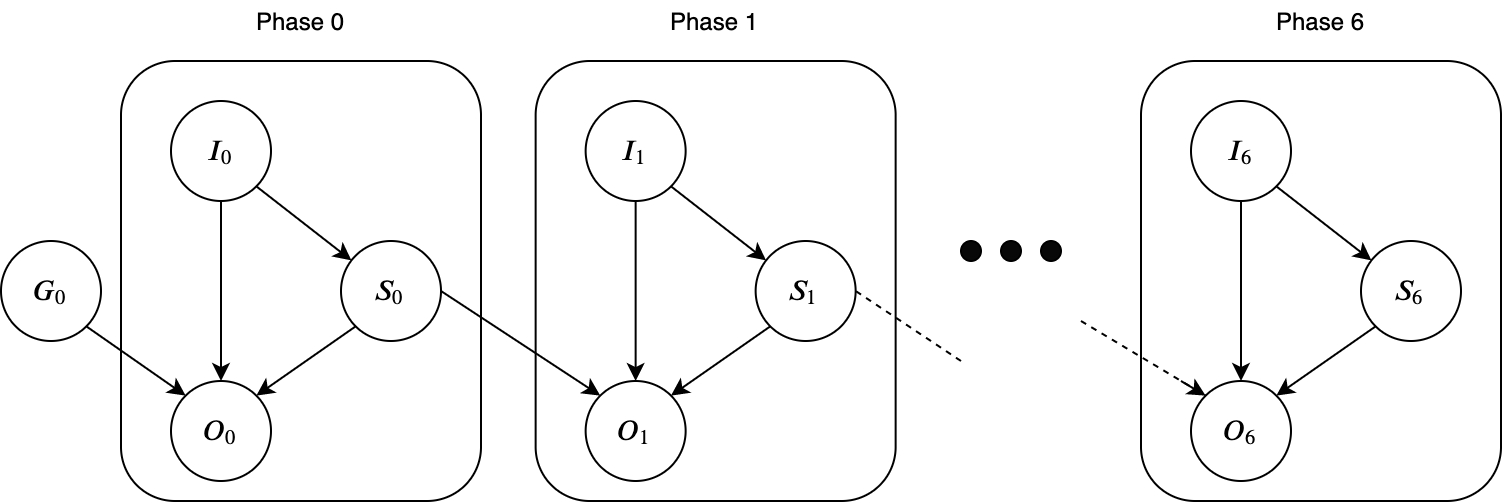

To specify $p(S_i| I_i)$, the probability over how many blueberries will transition in phase, given the number of blueberries at the start of the phase, we first decide on a normal distribution around the PHASE_SHIFT_DAYS variable, which is the average number of days that a blueberry will spend in that phase. Then the probability that a blueberry will transition to the next phase in the next 7 days is given by given by the cumulative distribution function evaluated at 7. If we assume the blueberries will transition phase independently, the number of blueberries that will transition has a Binomial distribution. In the visual examples below, in the first case the blueberry has a probability of 0.15 to transition to the next phase in the next 12 days.

Given more time I would investigate keeping this as a Binomial distribution, but for simple inference's sake, it is approximated by a normal distribution. This logic is computed in the ```get_shift_dist``` function below.

The mean of the distribution of $p(O_i|S_{i-1}, S_{i}, I_{i})$ is then simply calculated as the mean of the input minus the blueberries that will shift plus the blueberries that will start to grow or have shifted from a previous phase. All other parameters are chosen somewhat arbitrarily in the hope that the data will correct these priors.

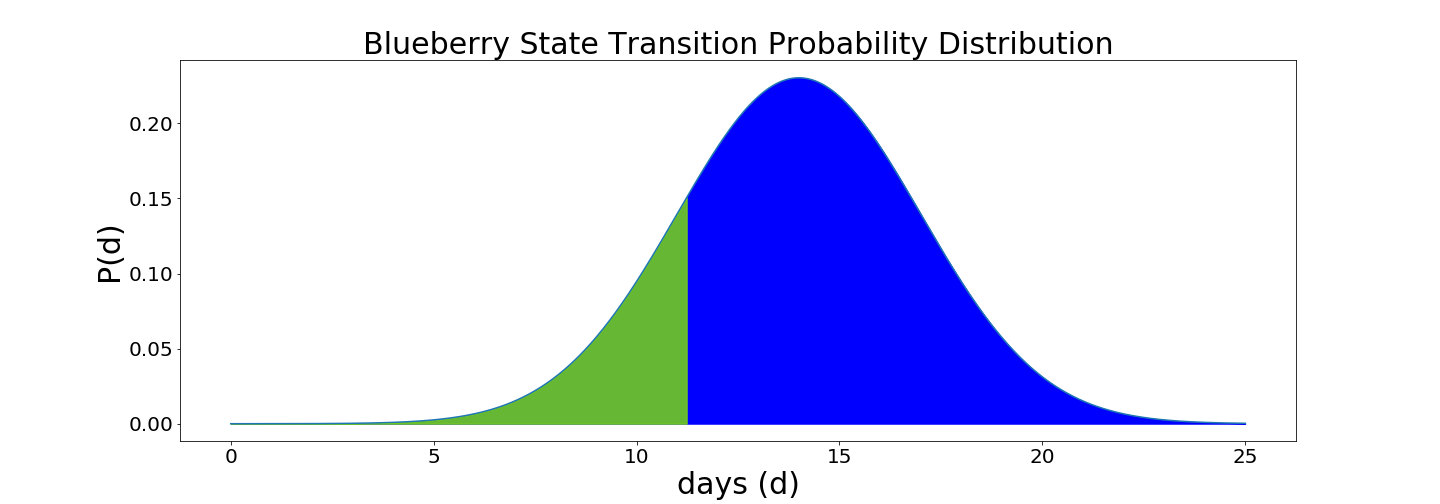

### Evaluation

The advantage of a graphical model is that the output is a posterior distribution and not just a point estimate. As a very simple accuracy metric, I have decided to count a sample as "accurate" if the true value falls in the prediction interval. Granted, for this problem the prediction interval is quite large, possibly due to the fact that there are so few samples. I think the method, however, warrants further investigation and there is still much room for improvement and more complex modelling choices that can be made.

### Blueberry weight prediction

Since we have a posterior over the number of blueberries to reach the blue phase after 7 days, we can sample from this distribution. Additionally, we can calculate the average weight per blueberry for each week. This distribution appears to follow a Gamma distribution. If we sample from this distribution too, we can come up with a distribution over the total weight by simply multiplying the two quantities. For evaluation we use the mean squared error metric.

In [4]:
class BlueberryModel():
    
    def __init__(self):
        self.inputs = None
        self.shifts = None
        self.grow = None
        self.outputs = None
        self.latent_vars = None
        self.q_grow = None
        self.latent_var_dict = None
        self.input_ph = None
        self.output_ph = None
        self.sess = None
        self.gamma_params = None
        
    def build_model(self):
        self.inputs = [0] * PHASES
        self.shifts = [0] * PHASES
        self.grow = [0] * PHASES
        self.outputs = [0] * PHASES
        for i in range(PHASES):
            self.inputs[i] = edm.Normal(20., 7., sample_shape=[N])
            shiftmean = self.get_shift_dist(self.inputs[i], PHASE_SHIFT_DAYS[i], PHASE_SHIFT_DAYS[i]/2.)
            self.shifts[i] = edm.Normal(shiftmean, PHASE_SHIFT_DAYS[i]/2.)
            self.grow[i] = self.shifts[i - 1] if i > 0 else edm.Normal(20.,7., sample_shape=[N])
            self.outputs[i] = edm.Normal(self.inputs[i] - self.shifts[i] + self.grow[i], self.inputs[i].scale + self.shifts[i].scale + self.grow[i].scale)
    
    @staticmethod
    def get_shift_dist(n, phase_mean, phase_stddev, days=7.):
        p = norm.cdf(days,phase_mean, phase_stddev)
        return n * p.astype('float32')
    
    def build_latent_vars(self):
        self.latent_vars = [0] * PHASES
        self.q_grow = edm.Normal(loc=tf.Variable(tf.random_uniform([])),
                scale=tf.Variable(tf.random_uniform([])), sample_shape=[N])
        for i in range(PHASES):
            self.latent_vars[i] = edm.Normal(loc=tf.Variable(tf.random_uniform([])),
                scale=tf.Variable(tf.random_uniform([])), sample_shape=[N])
            
    def create_latent_var_dict(self):
        self.latent_var_dict = {self.grow[0]: self.q_grow}
        self.latent_var_dict.update({key: value for key, value in zip(self.shifts, self.latent_vars)})
        
    def create_placeholder(self):
        placeholder = [0] * PHASES
        for i in range(0, PHASES):
            placeholder[i] = tf.placeholder(tf.float32, shape=[N])
        return placeholder    
    
    def create_data_dict(self):
        self.data_dict = {}
        self.data_dict.update({key: value for key, value in zip(self.inputs, self.input_ph)})
        self.data_dict.update({key: value for key, value in zip(self.outputs, self.output_ph)})
    
    def initialize(self):
        tf.reset_default_graph()
        with tf.name_scope("model"):
            self.build_model()
        self.sess = ed.get_session()
        with tf.name_scope("posterior"):
            self.build_latent_vars()
            
        # Create placeholders for the observed data
        self.input_ph = self.create_placeholder()
        self.output_ph = self.create_placeholder()
        
        # Create dictionaries for the latent variables and the observed data (with placeholders for now)
        self.create_latent_var_dict()
        self.create_data_dict()
    
    def do_inference(self, samples):
        n_batches = samples.shape[0] // N

        inf = edi.KLqp(self.latent_var_dict, data=self.data_dict)
        inf.initialize(n_iter=100 * n_batches, n_samples=10)

        self.sess.run(tf.global_variables_initializer())

        for i in range(inf.n_iter):
            data_index = i * N % samples.shape[0]

            # Populate the placeholders
            feed_dict = {}
            # Add inputs, one for each phase
            feed_dict.update({key: [value] for key, value in zip(self.input_ph, samples[data_index, 0:PHASES])})
            # Add outpust, one for each phase
            feed_dict.update({key: [value] for key, value in zip(self.output_ph, samples[data_index, PHASES:2*PHASES])})

            info_dict = inf.update(feed_dict=feed_dict)
            inf.print_progress(info_dict)
            
    def predict(self, samples):
        # copy posterior
        x_post = ed.copy(self.outputs[-1], self.latent_var_dict)
        sess=self.sess
        predictions = np.zeros((samples.shape[0], 3))
        for i in range(0, samples.shape[0]):
            feed_dict = {}
            feed_dict.update({key: [value] for key, value in zip(self.input_ph, samples[i, 0: PHASES])})
            quantile_1, quantile_2, mean = sess.run([x_post.quantile(0.025), x_post.quantile(0.975), x_post.mean()], 
                                                    feed_dict=feed_dict)
            predictions[i, :] = [quantile_1, mean, quantile_2]

        return predictions
            
    def evaluate_model(self, samples):
        predictions = self.predict(samples[:,0: PHASES])
        accuracy = self.calc_accuracy(samples[:, -1], predictions)
        print('Model accuracy:', accuracy, '%')
        
    def fit_weight_prediction(self, weight_data):
        self.gamma_params=stats.gamma.fit(weight_data.avg_blueberry_weight)
                              
        
    def predict_weight(self, samples):
        
        predictions = np.zeros((samples.shape[0], SAMPLES_WEIGHTS))
        for i in range(0, SAMPLES_WEIGHTS):
            print('Sampling from the blueberry number distribution, iteration:', i)
            predictions[:, i] = self.predict(samples)[:,1]
        weight_samples = gamma(self.gamma_params[0], self.gamma_params[1], self.gamma_params[2]).rvs((samples.shape[0], SAMPLES_WEIGHTS))
        weight_predictions = predictions*weight_samples
        mean_weights = np.mean(weight_predictions, axis=1)
        stddev_weights = np.std(weight_predictions, axis=1)

        return mean_weights, stddev_weights
    
    def evaluate_weight_prediction(self, weights):
        self.fit_weight_prediction(weights)
        mean_weights, stddev_weights = self.predict_weight(samples)
        _, p_val = stats.kstest(weights.avg_blueberry_weight, 'gamma', args=self.gamma_params)
        mse = ((mean_weights - weights.weight.values[:-1])**2).mean()
        if p_val < 0.05:
            print('This is a bad approximation')
        else:
            print('The gamma distribution seems to be a good fit.')
        print('Mean squared error for blueberry weight prediction:', mse)
        
    @staticmethod
    def calc_accuracy(samples, predictions):
        return ((samples > predictions[:,0]) & (samples < predictions[:,2])).sum()/len(samples)*100.
    
    @staticmethod
    def save_model(filename):
        saver = tf.train.Saver()
        sess = ed.get_session()
        save_path = saver.save(sess, filename)
        print("Model saved to file: %s" % save_path)
            
            

## Read the data

In [5]:
df_weight = pd.read_csv('weight_data.csv')
df_count = pd.read_csv('count_data.csv')
df_merge = df_count.merge(df_weight, how='left', on='week')
df_merge.loc[:, 'avg_blueberry_weight'] = df_merge.weight/df_merge.blue
df_merge = df_merge.replace(np.inf, None).dropna(subset=['avg_blueberry_weight'])
# samples used to predict blueberry numbers in last phase
df = df_merge[PHASE_COLUMNS]
samples = pd.concat([df,df.shift(-1)], axis=1).values[:-1,:] 
# weight data
weights = df_merge[['blue', 'avg_blueberry_weight', 'weight']]

In [6]:
for i in range(0,4):
    fold = np.random.choice(range(0,samples.shape[0]), (samples.shape[0],), replace=False)
    oot = fold[0:5]
    dev = fold[5:]
    tf.reset_default_graph()
    model = BlueberryModel()
    model.initialize()
    model.do_inference(samples[dev,:])
    predictions = model.predict(samples)
    model.fit_weight_prediction(weights)
    means, stddevs = model.predict_weight(samples)
    model.evaluate_model(samples[oot, :])
    model.evaluate_weight_prediction(weights)
    model.sess.close()

1200/1200 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 4491.780
Sampling from the blueberry number distribution, iteration: 0
Sampling from the blueberry number distribution, iteration: 1
Sampling from the blueberry number distribution, iteration: 2
Sampling from the blueberry number distribution, iteration: 3
Sampling from the blueberry number distribution, iteration: 4
Sampling from the blueberry number distribution, iteration: 5
Sampling from the blueberry number distribution, iteration: 6
Sampling from the blueberry number distribution, iteration: 7
Sampling from the blueberry number distribution, iteration: 8
Sampling from the blueberry number distribution, iteration: 9
Model accuracy: 60.0 %
Sampling from the blueberry number distribution, iteration: 0
Sampling from the blueberry number distribution, iteration: 1
Sampling from the blueberry number distribution, iteration: 2
Sampling from the blueberry number distribution, iteration: 3
Sampling from the blueberry num

## Future work

Predicting 7 days into the future is probably not really that useful. However, I think extending the model to predict an arbitrary number of days into the future should be fairly straightforward. I have also made the assumption that the dates between data points is exactly 7 days, which is not the case.

I have already mentioned that approximating the shift distribution as a Gaussian distribution is probably not the best idea, given the small number of data points, so keeping it a Binomial distribution warrants further investigation.

Modelling the weight and number of blueberries as a graphical model can also be investigated.

Furthermore, depending on the month of the year, a more informative prior on the growth can be incorporated. See for example the distribution below, found at https://www.saberries.co.za/wp-content/uploads/2019/07/BlueberryIndustryReport_2019FINAL.pdf.

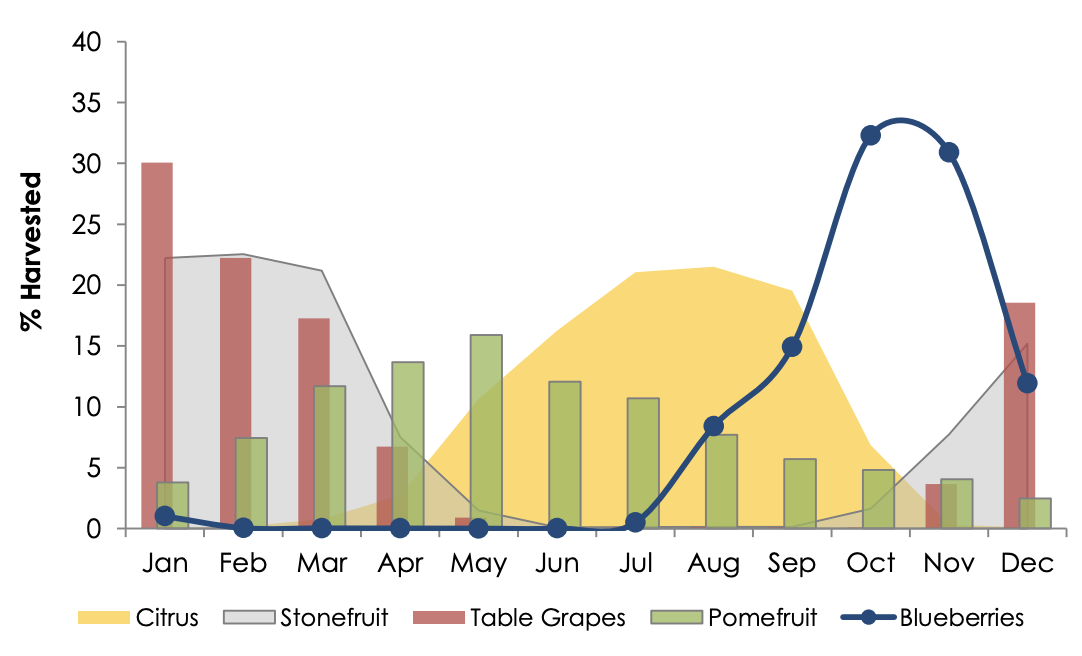